**4th European Conference on Social Networks**

**Workshop: Introduction to Python's Graph-Tool**
# Graph-tool basics: investigating mixing dynamics in networks.

**Author**: <a href='https://marcosoliveira.info/'>Marcos Oliveira</a>, GESIS - Leibniz Institute for the Social Sciences

**Version**: 9 Sep 2019

**Description**: Here we analyze mixing in networks in Python using the <code>graph-tool</code> library. 

**License**: <a href='https://www.gnu.org/licenses/gpl-3.0.en.html'>GNU General Public License 3.0</a>
    
## Imports and Settings

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

<div class="alert alert-danger">
    You need the <code>graph_tool</code> library in your machine. Sometimes the installation is challenging. This <a href=https://git.skewed.de/count0/graph-tool/wikis/installation-instructions>page</a> might help you.
</div>

In [2]:
import graph_tool.all as gt
print(gt.__version__)

2.28 (commit e5760dfc, Thu Jun 6 15:14:05 2019 +0100)


<div class="alert alert-warning">
    If you running this notebook via the GESIS infrastructure, you should set the number of threads as the following; otherwise, it will be slow.
</div>

In [3]:
# gt.openmp_set_num_threads(2)

In [4]:
def node_colors(g, group_memberships):
    """
        Given a graph and a group membership, this function returns 
        a vertex property with node color for each group.
    """
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
    to_rgb = lambda h: list(int(h[i:i+2], 16)/255. for i in (0, 2, 4))
    vertex_color = g.new_vertex_property('vector<double>')
    for m, v in zip(group_memberships, g.vertices()):
        vertex_color[g.vertex(v)] = tuple(to_rgb(colors[m % len(colors)][1:]) + [255.0])
    return vertex_color

# Mixing patterns
Here we are going to study the mixing patterns of a given network using ```graph-tool```.  

## Network
Let's load a network from the ```graph-tool``` library. 

In [5]:
g = gt.collection.data["polbooks"].copy()  # polbooks, polblogs, football

In [6]:
g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g = gt.Graph(g, prune=True)

In [7]:
g.is_directed()

False

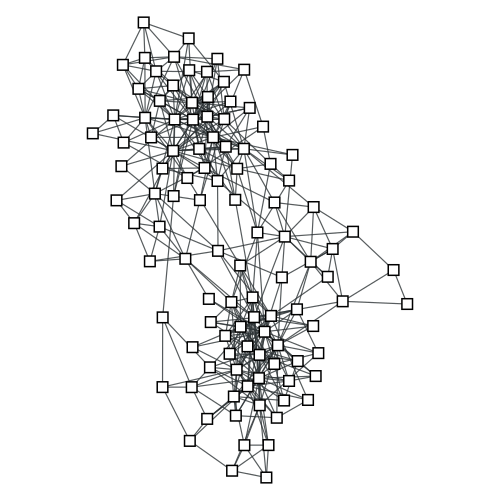

In [8]:
gt.graph_draw(
    g, 
    vertex_color="black", vertex_fill_color="white",
    vertex_size=15, vertex_shape="square",
    edge_pen_width=1.2, output_size=(500, 500));

## Metadata

This graph contains also metadata about the nodes in the vertex property ```value```.

In [9]:
g.vertex_properties['value']

<VertexPropertyMap object with value type 'string', for Graph 0x142aa09d0, at 0x142aa7390>

The 10 first values:

In [10]:
[g.vertex_properties['value'][v] for v in g.vertices()][:10]

['n', 'c', 'c', 'c', 'n', 'c', 'n', 'n', 'c', 'c']

The unique values:

In [11]:
unique_values = list(set([g.vertex_properties['value'][v] for v in g.vertices()]))
unique_values.sort()
unique_values

['c', 'l', 'n']

In [12]:
node_types_dict = dict(zip(unique_values, range(len(unique_values))))
node_types_dict

{'c': 0, 'l': 1, 'n': 2}

In [13]:
node_types = g.new_vertex_property("int") 
for v in g.vertices():
    node_types[v] = node_types_dict[g.vertex_properties['value'][v]]

## Visualizing metadata

Let's color the nodes with this information. For this, we use the ```node_colors``` helper:

In [14]:
colors = node_colors(g, node_types)

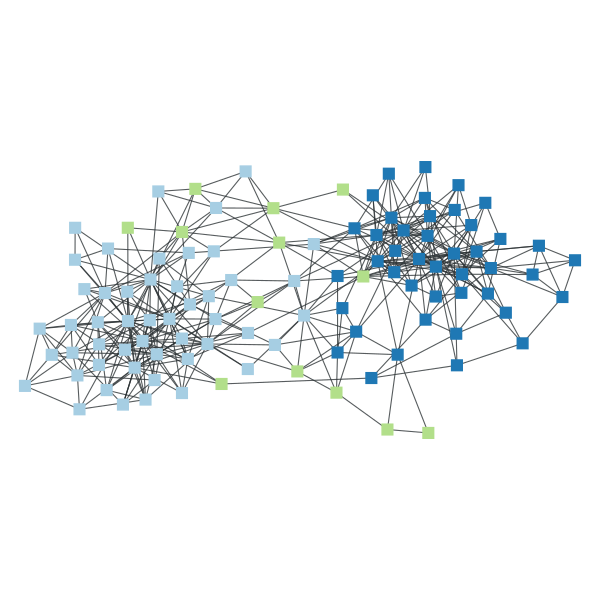

In [15]:
gt.graph_draw(
    g, 
    vertex_color=colors, vertex_fill_color=colors,
    vertex_size=15, vertex_shape="square",
    edge_pen_width=1.1, output_size=(600, 600));

It looks like we have some kind of meso-level structure here: nodes of the same type tend to connect among themselves. We can measure this via Newman's assortativity, as the following (<a href='https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.assortativity'>documentation</a>):

In [16]:
gt.assortativity(g, node_types)

(0.7233077584970601, 0.02815094042581091)

Newman's assortativity goes from -1 to 1, from a dissortative to an assortative network. In the case of zero, there is not evidence for assorativity/dissortativity.

# Data mixing matrix

We can analyze the number of edges inter- and intra-group to investigate the mixing in the network. In fact, Newman's assortativity is a measurment of this matrix.

To retrieve the mixing matrix of a network, we use the function <code>gt.<b>corr_hist()</b></code>.


<div class="alert alert-warning">
The signature of the <code>corr_hist</code> follows:
    
- graph_tool.correlations.<b>corr_hist</b>(g, deg_source, deg_target, bins=[[0, 1], [0, 1]], weight=None, float_count=True)

For now, let's focus on the <code>deg_source</code> and <code>deg_target</code> parameters (see the <a href="https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist">documentation</a> for more). 

 - The <code>deg_source</code> and <code>deg_target</code> parameters are the vertex properties. You can also use `in`, `out`, or `total`, if you want to use the degree property of the vertices.
</div>

Here we use the ```node_types```, which gives us the type of each node (i.e., meta data). 

In [17]:
node_types

<VertexPropertyMap object with value type 'int32_t', for Graph 0x142aa09d0, at 0x142abebd0>

In [18]:
data_mixing_matrix, bins = gt.corr_hist(g, node_types, node_types)

In [19]:
data_mixing_matrix

array([[380.,  12.,  34.],
       [ 12., 344.,  24.],
       [ 34.,  24.,  18.]])

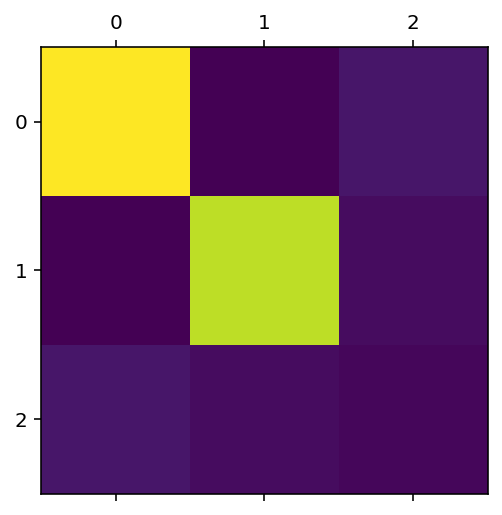

In [20]:
plt.matshow(data_mixing_matrix);
plt.xticks(range(data_mixing_matrix.shape[0]), bins[0]);
plt.yticks(range(data_mixing_matrix.shape[1]), bins[1]);

In [21]:
for (i, j), z in np.ndenumerate(data_mixing_matrix):
    print(i, j, z)

0 0 380.0
0 1 12.0
0 2 34.0
1 0 12.0
1 1 344.0
1 2 24.0
2 0 34.0
2 1 24.0
2 2 18.0


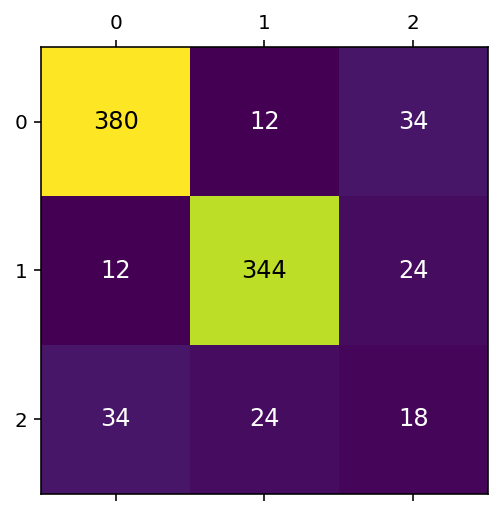

In [22]:
plt.matshow(data_mixing_matrix);
plt.xticks(range(data_mixing_matrix.shape[0]), bins[0])
plt.yticks(range(data_mixing_matrix.shape[1]), bins[1])
for (i, j), z in np.ndenumerate(data_mixing_matrix):
    plt.text(j, i, '%d' % z, ha='center', va='center', 
             color="white" if z < data_mixing_matrix.mean() else "black", fontsize=12)

Let's include the labels:

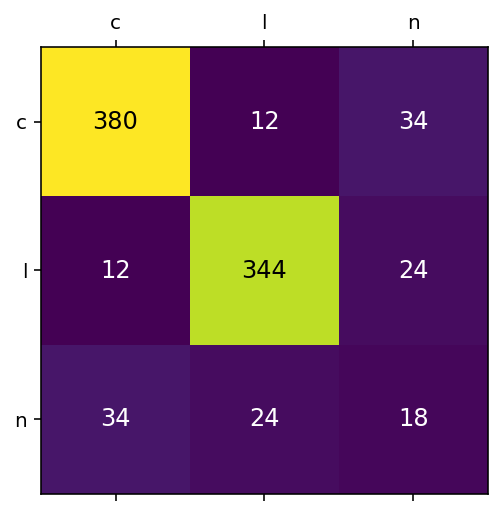

In [23]:
plt.matshow(data_mixing_matrix);
plt.xticks(range(data_mixing_matrix.shape[0]), [unique_values[l] for l in bins[0][:len(unique_values)]])
plt.yticks(range(data_mixing_matrix.shape[1]), [unique_values[l] for l in bins[0][:len(unique_values)]])
for (i, j), z in np.ndenumerate(data_mixing_matrix):
    plt.text(j, i, '%d' % z, ha='center', va='center', 
             color="white" if z < data_mixing_matrix.mean() else "black", fontsize=12)

We can analyze further this matrix by comparing it against a random version of our network.

# Generation

The <a href="https://graph-tool.skewed.de/static/doc/generation.html">generation module</a> of the ```graph-tool``` package enables us to generate networks using different models. Here we will use the configuration model to examine the mixing dynamics in our data.

## The Configuration Model
Let's first create a copy of our network:


In [24]:
null_model = g.copy()

```graph-tool``` is a bit picky about graph properties, we need to recreate them for this copy:

In [25]:
null_node_types = null_model.new_vertex_property("int") 
for v in null_model.vertices():
    null_node_types[v] = node_types_dict[null_model.vertex_properties['value'][v]]

We will create a random version of our network by rewire the edges of it while preserving its degree sequence. For this, we use the <code>gt.<b>random_rewire</b>()</code> function. 

<div class="alert alert-warning">
The signature of the <code>random_rewire</code> follows:
    
- graph_tool.generation.<b>random_rewire</b>(g, model='configuration', n_iter=1, edge_sweep=True, parallel_edges=False, self_loops=False, configuration=True, edge_probs=None, block_membership=None, cache_probs=True, persist=False, pin=None, ret_fail=False, verbose=False)

For now, let's focus on the <code>model</code> parameter (see the <a href="https://graph-tool.skewed.de/static/doc/generation.html#graph_tool.generation.random_rewire">documentation</a> for more). 

 - The <code>model</code> parameter determines how the edges are rewired. If we set <code>model='configuration'</code>, we use the configuration model in which the edges will be rewired but the degree sequence keeps the same.
</div>

In [26]:
gt.random_rewire(null_model, model='configuration');

In [27]:
mixing_matrix, bins = gt.corr_hist(null_model, null_node_types, null_node_types)

In [28]:
mixing_matrix

array([[202., 183.,  41.],
       [183., 172.,  25.],
       [ 41.,  25.,  10.]])

<div class="alert alert-info">
What is the difference between this matrix and the mixing matrix from data?
</div>

Let's use some heatmap again:

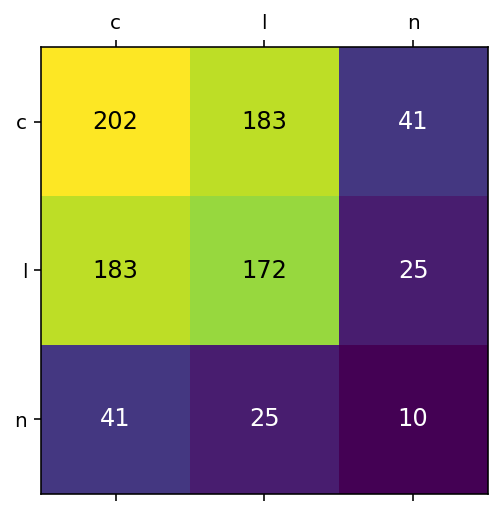

In [29]:
plt.matshow(mixing_matrix);
plt.xticks(range(mixing_matrix.shape[0]), [unique_values[l] for l in bins[0][:len(unique_values)]]);
plt.yticks(range(mixing_matrix.shape[1]), [unique_values[l] for l in bins[1][:len(unique_values)]]);
for (i, j), z in np.ndenumerate(mixing_matrix):
    plt.text(j, i, '%d' % z, ha='center', va='center', 
             color="white" if z < mixing_matrix.mean() else "black", fontsize=12)

## Comparing data to the networks generated by the configuration model
The rewiring is stochastic. Now we can follow this procedure several times and compare against our data. 

We create a function for rewiring:

In [30]:
def rewire_graph(g):
    null_model = g.copy()
    null_node_types = null_model.new_vertex_property("int") 
    for v in null_model.vertices():
        null_node_types[v] = node_types_dict[null_model.vertex_properties['value'][v]]
    gt.random_rewire(null_model, model='configuration')
    mixing_matrix, bins = gt.corr_hist(null_model, null_node_types, null_node_types)
    return mixing_matrix, bins

Then call it several times, say $N=500$:

In [31]:
mixing_matrices = []
for _ in range(500):
    mixing_matrix, bins = rewire_graph(g)
    mixing_matrices.append(mixing_matrix)

Let's see the number of intra-edges in the first group:

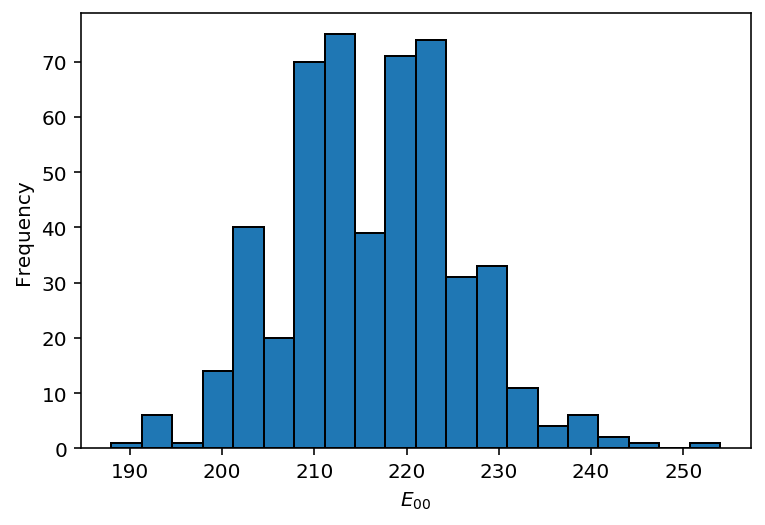

In [32]:
plt.hist([m[0, 0] for m in mixing_matrices], edgecolor='k', bins=20)
plt.xlabel("$E_{00}$")
plt.ylabel("Frequency");

We can compare this against our data:

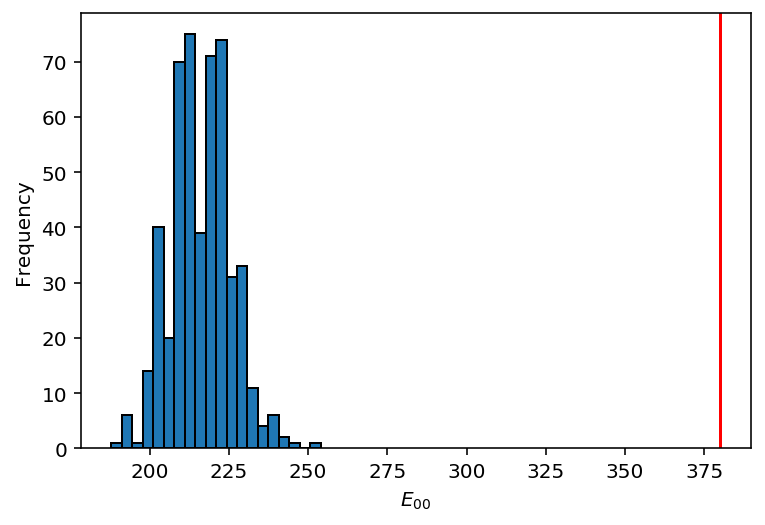

In [33]:
plt.hist([m[0, 0] for m in mixing_matrices], edgecolor='k', bins=20)
plt.axvline(data_mixing_matrix[0, 0], color='red');
plt.xlabel("$E_{00}$")
plt.ylabel("Frequency");

We can now have a z-scored mixing matrix from data:

In [34]:
np.mean(mixing_matrices, axis=0)

array([[216.312, 172.698,  36.99 ],
       [172.698, 174.62 ,  32.682],
       [ 36.99 ,  32.682,   6.328]])

In [35]:
np.std(mixing_matrices, axis=0)

array([[9.55984602, 8.60481237, 4.35957567],
       [8.60481237, 9.42547612, 4.13386937],
       [4.35957567, 4.13386937, 3.18816813]])

In [36]:
z_scored_mixing_matrix = (data_mixing_matrix - np.mean(mixing_matrices, axis=0))/np.std(mixing_matrices, axis=0)

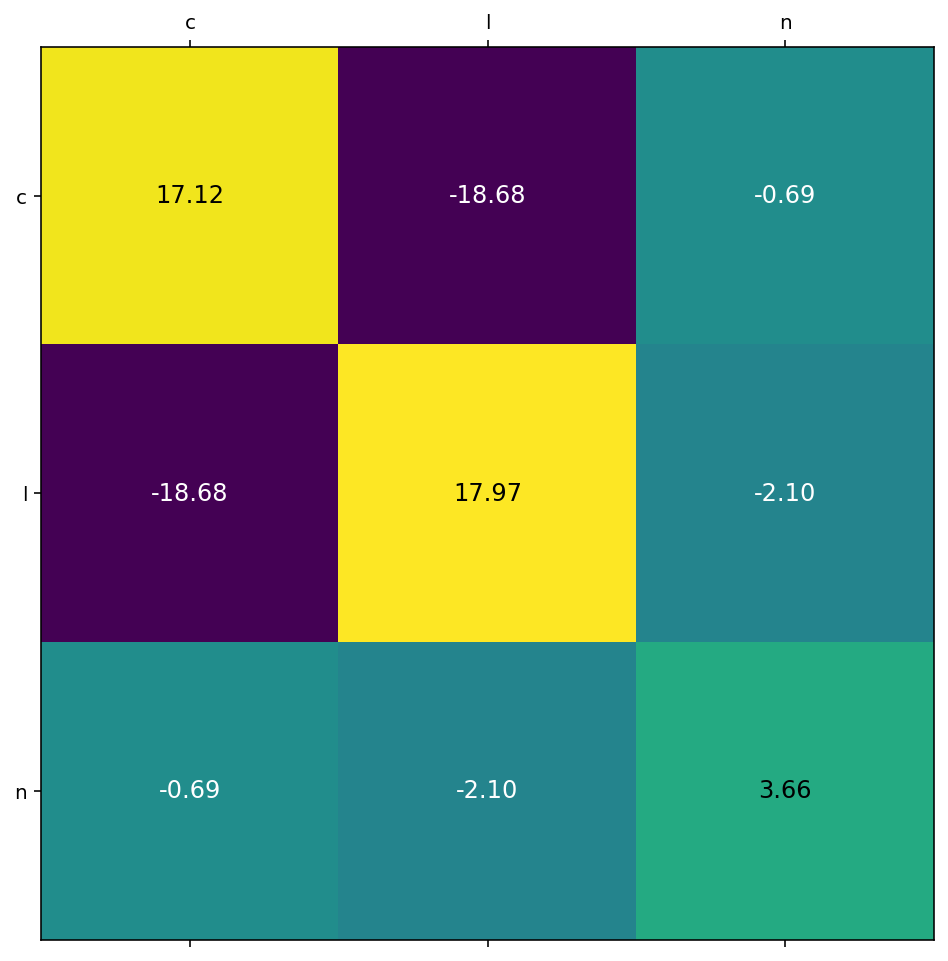

In [37]:
plt.figure(figsize=(8, 8))
plt.matshow(z_scored_mixing_matrix, fignum=1);
plt.xticks(range(z_scored_mixing_matrix.shape[0]), [unique_values[l] for l in bins[0][:len(unique_values)]]);
plt.yticks(range(z_scored_mixing_matrix.shape[1]), [unique_values[l] for l in bins[0][:len(unique_values)]]);
for (i, j), z in np.ndenumerate(z_scored_mixing_matrix):
    plt.text(j, i, '%.2f' % z, ha='center', va='center', 
             color="white" if z < z_scored_mixing_matrix.mean() else "black", fontsize=12)

# Exercises

<div class="alert alert-success">

**Exercise 1** 

Rewire the network with different models and compare against the data. For this, change the parameter ```model``` in ```random_rewire``` (see the <a href="https://graph-tool.skewed.de/static/doc/generation.html#graph_tool.generation.random_rewire">documentation</a>). 
</div>

<div class="alert alert-success">

**Exercise 2** 

Load your own data set (or use a data set from the library) and study the mixing patterns in the network. 
</div>